<div class="alert alert-success">
<b>Reviewer's comment V3</b>

Thanks for taking the time to improve the project! It is accepted, and you can move on to the next sprint! Keep up the good work! :)

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a pretty good job overall, but there are a couple of problems that need to be fixed before the project is accepted. Let me know if you have any questions!


# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation
Initially I will import the necessary libraries and do preliminary observations of the condition of the data. 

In [1]:
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
#check data, assign datetime column as index, convert to datetime object
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=True)

#check if data is sorted
print(data.index.is_monotonic)
print()

#check info
data.info()
print()

#check first few rows
data.head()

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB



,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<div class="alert alert-success">
<b>Reviewer's comment</b>

Good idea to check that the time series is in correct order!

</div>

In [3]:
# check for NaN
data.isna().sum()

num_orders    0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


I see no null values, the datatype is appropriate. The data is ready for analysis. Now I will resample the data by the hour 

In [5]:
#resample by hour, aggregation = sum
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly

</div>

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Analysis
Now I will look into the seasonality and any trends present 

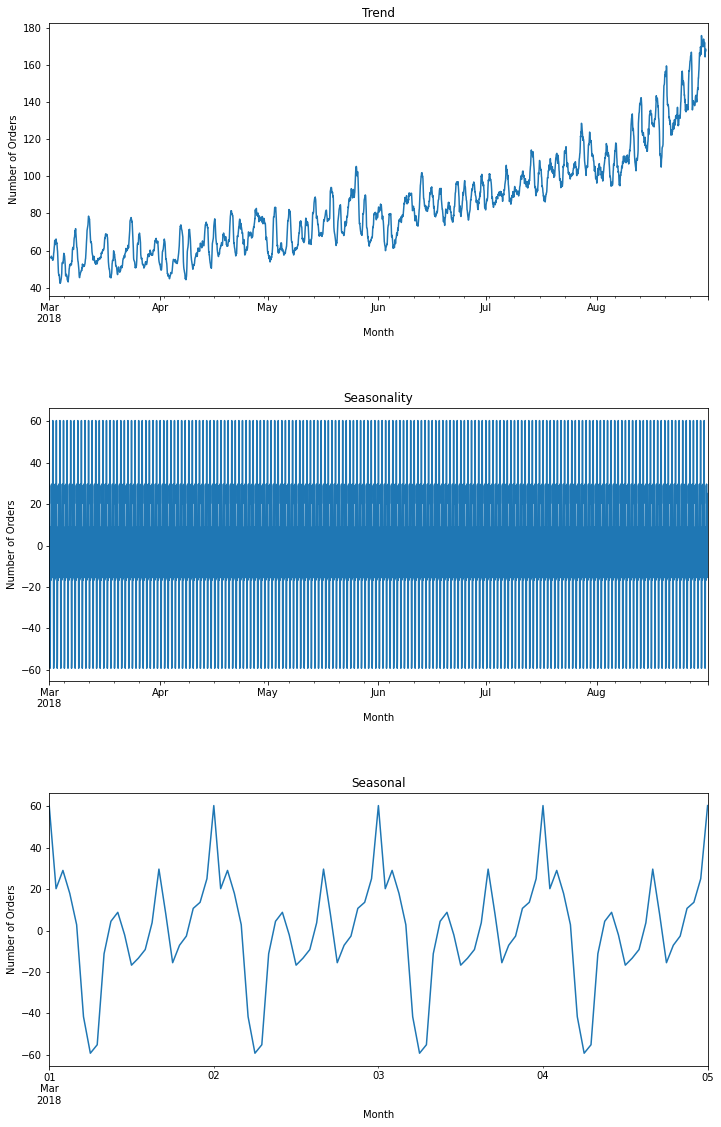

In [7]:
#get different attributes of our time series
decomposed = seasonal_decompose(data)

#specify fig size for all plots
plt.figure(figsize=(10,15))

#3 rows, 1 column, image 1
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca()) #specifying axis to display graph correctly
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#subplot configuration to prevent overlap
plt.tight_layout(h_pad=7)

#image 2
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Month')
plt.ylabel('Number of Orders')

#image 3
plt.subplot(313)
decomposed.seasonal['2018-03-01 00:00:00': '2018-03-05 00:00:00'].plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.show()


<div class="alert alert-warning">
<b>Reviewer's comment</b>

The x axis label of the last plot is incorrect

</div>

From these plots we can see that there is a positive trend moving into the summer months, and at the start of the day there is a peak in taxi orders, followed by a drop and then an increase into the end of the day 

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, you did a seasonal decompostition and noted some patterns!

</div>

## Training

To start I will design a funtion for feature engineering. This extraction the day of the week, month, day, and year. As well as the previous days cycle and a series of 3 lags. These features will be very useful in training our model to predict the number of orders 

In [8]:
def make_features(data, max_lag):
    data = data.copy(deep=True)
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    #seasons last 1 day, so we'll create a column that utilizes the previous cycle
    data['previous_day'] = data['num_orders'].shift(24)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(7).mean()
    
    
    data = data.dropna()
    return data

full_data = make_features(data, 6)
full_data.head()

,num_orders,hour,month,day,dayofweek,previous_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,3,2,4,124.0,58.0,113.0,66.0,61.0,45.0,73.0,65.714286
2018-03-02 01:00:00,120,1,3,2,4,85.0,90.0,58.0,113.0,66.0,61.0,45.0,72.285714
2018-03-02 02:00:00,75,2,3,2,4,71.0,120.0,90.0,58.0,113.0,66.0,61.0,79.000000
2018-03-02 03:00:00,64,3,3,2,4,66.0,75.0,120.0,90.0,58.0,113.0,66.0,83.285714
2018-03-02 04:00:00,20,4,3,2,4,43.0,64.0,75.0,120.0,90.0,58.0,113.0,83.714286


<div class="alert alert-warning">
<b>Reviewer's comment</b>

Feature extraction looks good: there are calendar features and lag features. One omission is an hour feature. On the other hand, year is not useful as it is constant in our data.

</div>

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Next hour's number of orders can't be used as a feature: this is data from the future :)

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Ok, great! Now there is an hour feature, and next hour was removed

</div>

In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hour          4392 non-null   int64  
 2   month         4392 non-null   int64  
 3   day           4392 non-null   int64  
 4   dayofweek     4392 non-null   int64  
 5   previous_day  4392 non-null   float64
 6   lag_1         4392 non-null   float64
 7   lag_2         4392 non-null   float64
 8   lag_3         4392 non-null   float64
 9   lag_4         4392 non-null   float64
 10  lag_5         4392 non-null   float64
 11  lag_6         4392 non-null   float64
 12  rolling_mean  4392 non-null   float64
dtypes: float64(8), int64(5)
memory usage: 480.4 KB


Now that we have our features we are ready to split our data and make a function for our evaluation metric.

In [10]:
# function to define metric
def rmse(true, pred):
    return mean_squared_error(true, pred)**0.5

In [11]:
#get train and test sets
train, test = train_test_split(full_data, shuffle = False, test_size = 0.1)
train, valid = train_test_split(train, shuffle = False, test_size = 0.1)

features_train = train.drop('num_orders', axis = 1)
features_valid = valid.drop('num_orders', axis = 1)
target_train = train['num_orders']
target_valid = valid['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

#check size
print('features_train size:', features_train.shape[0])
print('features_valid size:', features_valid.shape[0])
print('features_test size:', features_test.shape[0])
print('target_train size:', target_train.shape[0])
print('target_valid size:', target_valid.shape[0])
print('target_test size:', target_test.shape[0])

features_train size: 3556
features_valid size: 396
features_test size: 440
target_train size: 3556
target_valid size: 396
target_test size: 440


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling

</div>

## Testing

In [12]:
# time series split
tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


### Linear Regression

In [13]:
lr_model = LinearRegression()

lr_model.fit(features_train, target_train)

lr_train_prediction = lr_model.predict(features_valid)
print("RMSE for the training set:",  rmse(target_valid, lr_train_prediction) )

RMSE for the training set: 35.56636943399032


<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

The test set should not be used here.
    
The first RMSE value is actually for the validation set, not the train set, right?

</div>

### Random Forest

In [14]:
rf = RandomForestRegressor()

rf_model = rf.fit(features_train,target_train)

rf_prediction = rf_model.predict(features_valid)
print("Random Forest Regressor RMSE : ", rmse(target_valid, rf_prediction))

Random Forest Regressor RMSE :  32.73761218793571


### Random Forest with hyperparameter tuning

In [15]:
grid = {
    "n_estimators" : [100, 200],
    "max_depth" : [None, 2, 4, 6],
    "min_samples_leaf" : [2, 4]
}
# define the model 
regressor = RandomForestRegressor(random_state = 12345)
# define the grid search
grid_search_rf = GridSearchCV(estimator = regressor, 
                              param_grid = grid, 
                              scoring="neg_mean_squared_error", 
                              cv=tscv)
# execute search
grid_search_rf.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_rf.best_params_))

The best hyperparameters are: {'max_depth': None, 'min_samples_leaf': 4, 'n_estimators': 100}


In [16]:
rf_model = RandomForestRegressor(**grid_search_rf.best_params_)

rf_model.fit(features_train, target_train)

rf_pred = rf_model.predict(features_valid)

rf_rmse = rmse(target_valid, rf_pred)


In [17]:
print("Random Forest with Hyperparameters :", rf_rmse)

Random Forest with Hyperparameters : 32.759969008171


### LightGBM Regressor

In [18]:
lgbm_grid = {'learning_rate': [0.05, 0.1],
             'n_estimators': [500, 800, 1000],
             'num_leaves': [2,3,5]
            }
# define the model 
lgbm_regr = LGBMRegressor(random_state = 12345)

# define the grid search
grid_search_lgbm = GridSearchCV(
    estimator = lgbm_regr, 
    param_grid = lgbm_grid, 
    scoring = "neg_mean_squared_error", 
    cv = tscv, 
    n_jobs = 1
)
# execute search
grid_search_lgbm.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_lgbm.best_params_))

results = grid_search_lgbm.cv_results_
#get best index
best_index = grid_search_lgbm.best_index_

#get results
fit_time = results['mean_fit_time'][best_index]
score_time = results['mean_score_time'][best_index]
RMSE = (grid_search_lgbm.best_score_*-1)**0.5

print('Fit time:', fit_time)
print('Score time:', score_time)
print('RMSE:', RMSE)

The best hyperparameters are: {'learning_rate': 0.05, 'n_estimators': 800, 'num_leaves': 5}
Fit time: 0.6375446319580078
Score time: 0.038527631759643556
RMSE: 23.79300765701394


In [19]:
lgbm_model = LGBMRegressor(**grid_search_lgbm.best_params_)
lgbm_model.fit(features_train, target_train)
    
lgbm_pred = lgbm_model.predict(features_valid)
    # determine RMSE for LightGBM regressor
lgbm_rmse = rmse(target_valid, lgbm_pred)
    
print('RMSE: {:.3f}'.format(lgbm_rmse))


RMSE: 31.909


### XGBoost

In [20]:
xgb_grid = {'learning_rate':  [0.01, 0.1], 
            'max_depth': [2, 4],
            'n_estimators': [50, 100]
           }
# define the model 
xgb_regr = XGBRegressor(random_state = 12345)

# define the grid search
grid_search_xgb = GridSearchCV(
    estimator = xgb_regr, 
    param_grid = xgb_grid, 
    scoring = "neg_mean_squared_error", 
    cv = tscv, 
    n_jobs = 1
)
# execute search
grid_search_xgb.fit(features_train, target_train)
# summarize result
print('The best hyperparameters are: {}'.format(grid_search_xgb.best_params_))

The best hyperparameters are: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [21]:
xgb_model = XGBRegressor(**grid_search_xgb.best_params_)

xgb_model.fit(features_train, target_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [22]:
xgb_pred = xgb_model.predict(features_valid)
    
xgb_rmse = rmse(target_valid, xgb_pred)
print("\033[1m" + 'RMSE using XGBoost Regressor' + "\033[0m")
print('RMSE: {:.3f}'.format(xgb_rmse))

RMSE using XGBoost Regressor
RMSE: 32.918


<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Three problems:
    
1. The test set should only be used to evaluate the final model after we're done with model selection, hyperparameter tuning, etc. If we use the test set to make any decisions about the models, the final model's test set score will be overly optimistic.
    
2. Train set score is not useful to compare the models: it only tells us how well the model memorized the train set, but not how well it will generalize to new data. That's why we need to use either a separate validation set or cross-validation to compare the models and tune hyperparameters.

3. The default k-fold cross-validation is not appropriate for time series models: due to mixing of train and validation data in all folds but one it causes data leakage. The solution is to use a different split: [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) (you can just pass an object of this class as the `cv` parameter to `GridSearchCV`, `cross_val_score` and so on)

</div>

<div class="alert alert-warning">
<b>Reviewer's comment V2</b>

The problems were fixed!
   
Note that if you use cross-validation anyway, you could just take the `best_score_` of the grid search object and use it to compare the models (it contains the cross-validation score of the best model) instead of using a separate validation set. For linear regression you can use `cross_val_score` with a time series split.

</div>

## Final test
I will perform the final test using the test dataset on the random forest regressor because it provided me with the best score in training. I will retrain the model on the concatonated training and validation datasets. 

In [23]:
features_train_test=pd.concat([features_valid, features_train])

print(features_train_test.shape[0])

features_train_test.head()

3952


,hour,month,day,dayofweek,previous_day,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,rolling_mean
datetime,,,,,,,,,,,,
2018-07-28 04:00:00,4,7,28,5,109.0,132.0,145.0,195.0,192.0,122.0,213.0,161.714286
2018-07-28 05:00:00,5,7,28,5,64.0,215.0,132.0,145.0,195.0,192.0,122.0,173.428571
2018-07-28 06:00:00,6,7,28,5,78.0,91.0,215.0,132.0,145.0,195.0,192.0,156.000000
2018-07-28 07:00:00,7,7,28,5,44.0,44.0,91.0,215.0,132.0,145.0,195.0,144.857143
2018-07-28 08:00:00,8,7,28,5,89.0,39.0,44.0,91.0,215.0,132.0,145.0,123.000000


In [24]:
target_train_test=pd.concat([target_valid, target_train])

In [25]:
print(target_train_test.shape[0])

target_train_test.head()

3952


datetime
2018-07-28 04:00:00    215
2018-07-28 05:00:00     91
2018-07-28 06:00:00     44
2018-07-28 07:00:00     39
2018-07-28 08:00:00     73
Name: num_orders, dtype: int64

In [26]:
rf_model.fit(features_train_test, target_train_test)
rf_pred_test = rf_model.predict(features_test)

rf_rmse_test = rmse(target_test, rf_pred_test)

print("Random Forest Regressor Final RMSE :", rf_rmse_test)

Random Forest Regressor Final RMSE : 44.20187726877742


<div class="alert alert-success">
<b>Reviewer's comment</b>

The final model was evaluated on the test set.

</div>

# Conclusion
The Random Forest Regressor provided a final score of 44.2on the final test. This is above the threshold of 48 that our client has set. I tested many different models with hyperparameter tuning, however, I was unable to get a test result of 48 or below. I believe I may be able to achieve a better result with a larger test set.  

<div class="alert alert-danger">
<s><b>Reviewer's comment V2</b>

Not sure how a larget test set is supposed to help get better results :)
    
Getting RMSE lower than 48 is a requirement in this project though. One suggestion I have is to refit the final model on the combined train+validation data before evaluating it on the test set. Now you have a gap between train and test data which may be problematic for time series models (especially if there is a growing trend which you observed).

</div>

Thank you so much, I was absolutely at a loss. That worked! -Johannah 

<div class="alert alert-success">
<b>Reviewer's comment V3</b>

You're welcome! :)

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48